In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# loading keras and FBD experiment...
from keras import backend as K
K.set_floatx('float32')
from helpers import *
from experiment import *
from matplotlib import pyplot as plt
import pickle
from tqdm import tqdm
import sys
import numpy as np

# to show the model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras import Model, Input
from keras.layers import Activation, InputLayer

# loading resnet
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions

# for softplus
from vis.utils.utils import apply_modifications
from keras.activations import softplus
from keras.utils import CustomObjectScope

Using TensorFlow backend.


Initialized TensorFlow


In [2]:
# creating resnet model
model = VGG16(weights = 'imagenet')

In [3]:
def softplus10(x):
    scaler = 10.0
    return softplus(x * scaler) / scaler

In [4]:
# replacing ReLU with SoftPlus10
for i, layer in enumerate(model.layers):
    if hasattr(layer, 'activation'):
        if layer.activation.__name__ == 'relu':
            layer.activation = softplus10
            #print(i)
            #print(layer.activation.__code__)

In [5]:
with CustomObjectScope({'softplus10': softplus10}):
    model = apply_modifications(model)

/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [6]:
# downscale image side
d = 50

# new (small) input
input_tensor = Input(shape = (d, d, 3))

# new model taking small images and upscaling them
out = model(Lambda(lambda x : tf.image.resize_images(x, (224, 224)))(input_tensor))
model_upscale = Model(inputs = input_tensor, outputs = out)

In [19]:
model_upscale.layers[-1].layers[-2].activation

<function __main__.softplus10(x)>

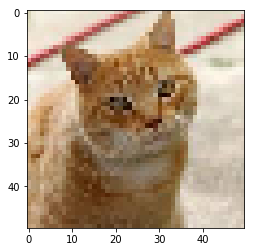

In [20]:
# getting picture of a cat
img_path = 'cat.jpg'
img = image.load_img(img_path, target_size=(d, d))
plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [21]:
decode_predictions(model_upscale.predict(x), top=3)[0]

[('n02124075', 'Egyptian_cat', 0.10491509),
 ('n02129165', 'lion', 0.07763003),
 ('n02127052', 'lynx', 0.0698496)]

In [22]:
# probability of input failure
p = 0.0001

In [23]:
# calculating np
n = np.prod(list(map(int, model_upscale.inputs[0].shape[1:])))
n, n * p

(7500, 0.75)

In [24]:
to_keep = np.array(np.argsort(-model_upscale.predict(x))[0][:5], dtype = np.int32)

In [25]:
def SliceLayer(to_keep):
    """ Keep only these components in the layer """
    return Lambda(lambda x : tf.gather(x, to_keep, axis = 1))

In [26]:
to_keep

array([285, 291, 287, 282, 674], dtype=int32)

In [27]:
model_slice = Model(inputs = model_upscale.input, outputs = SliceLayer(to_keep)(model_upscale.output))

In [28]:
class ModelInputCrashExperiment(Experiment):
    def __init__(self, model, p=0.01, name='exp'):
        """ Get an experiment based on a model, assuming input failures
            p failures at input
        """

        # saving p_inference
        self.p_inference = [0, p]
        
        in_shape = model.layers[0].input.shape[1:]
        out_shape = model.layers[-1].output.shape[1:]
        assert len(out_shape) == 1, "Only support 1D output"
        out_N = int(out_shape[0])

        # rewrite using https://github.com/raghakot/keras-vis/issues/37
        self.N = [0, 0, out_N]

        def IdentityLayer(input_shape=None):
            """ A layer which does nothing """
            return Lambda(
                lambda x: x + 0, input_shape=input_shape, name='Identity')

        # creating correct and crashing models
        inp = Input(shape = in_shape)
        self.model_correct  = Model(inputs = inp, outputs = model(IdentityLayer     (   input_shape = in_shape)(inp)))
        self.model_crashing = Model(inputs = inp, outputs = model(IndependentCrashes(p, input_shape = in_shape)(inp)))

In [29]:
# obtaining experiment from a model
exp = ModelInputCrashExperiment(model_slice, p = p)

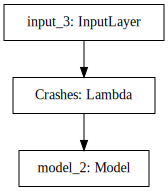

In [30]:
# plotting crashing architecture
SVG(model_to_dot(exp.model_crashing).create(prog='dot', format='svg'))

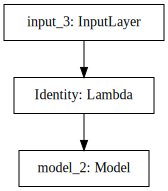

In [31]:
# plotting correct architecture
SVG(model_to_dot(exp.model_correct).create(prog='dot', format='svg'))

In [32]:
def predict(model, x):
    preds = model.predict(x)
    result = np.zeros(1000)
    preds = model.predict(x)
    for i, key in enumerate(to_keep):
        result[key] = preds[0][i]
    result = result.reshape(-1, 1000)
    print('Predicted:', decode_predictions(result, top=3)[0])

In [36]:
predict(exp.model_crashing, x)

Predicted: [('n02124075', 'Egyptian_cat', 0.10358436405658722), ('n02129165', 'lion', 0.07231560349464417), ('n02127052', 'lynx', 0.06617271155118942)]


In [37]:
predict(exp.model_correct, x)

Predicted: [('n02124075', 'Egyptian_cat', 0.104915089905262), ('n02129165', 'lion', 0.07763002812862396), ('n02127052', 'lynx', 0.06984960287809372)]


In [38]:
r = exp.get_bound_b3(x)

In [39]:
r['mean']

array([-7.1225218e-06, -3.8279309e-06,  3.8466044e-07, -3.0214815e-06,
       -3.7422678e-06], dtype=float32)

In [45]:
np.mean(exp.compute_error(np.array(x), repetitions = 1000), axis = 1)

array([[-4.5405858e-04, -5.6042522e-04, -9.3026331e-04, -3.0546758e-04,
        -5.7000030e-05]], dtype=float32)

In [46]:
K = 1000
k = 100

In [ ]:
datas = [exp.compute_error(np.array(x), repetitions = K) for _ in tqdm(range(k))]

  4%|▍         | 4/100 [00:12<04:58,  3.11s/it]

In [3]:
fn = 'ConvNetTest-ResNet.pkl'

In [44]:
pickle.dump(datas, open(fn, 'wb'))

In [4]:
datas = pickle.load(open(fn, 'rb'))

In [15]:
np.mean(np.hstack(datas), axis = 1)

array([[-2.19074500e-04,  3.42124316e-04, -1.05700055e-04,
        -9.17126727e-06,  1.58215460e-06]], dtype=float32)

In [42]:
exp.model_correct.layers[1]

In [46]:
exp.model_correct.layers[0].output

<tf.Tensor 'input_2:0' shape=(?, 224, 224, 3) dtype=float32>